In [21]:
# Importacion de librerias 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

In [22]:
# Importacion de datos 

data_train = pd.read_csv('gold_recovery_train.csv')
data_test = pd.read_csv('gold_recovery_test.csv') 
data_full = pd.read_csv('gold_recovery_full.csv')

# 1. Analisis Exploratorio 

## Conjunto de entrenamiento

In [23]:
# Data Train

# Examinar datos 
print(f'La forma del los datos es de: {data_train.shape}\n')
print(data_train.info())

print(data_train.isnull().sum())

La forma del los datos es de: (16860, 87)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol            

In [24]:
def data_preprocessing(data, is_train=True):    
    # Cambiar tipo de dato de la columna date 
    data['date'] = pd.to_datetime(data['date'])

    # Eliminar duplicados 
    data = data.drop_duplicates(subset='date').sort_values('date')

    # Rellenar valores nulos usando la mediana
    for col in data.columns: 
        if data[col].dtype != 'object':
            data[col] = data[col].fillna(data[col].median())
    
    # Eliminar filas donde faltan datos (solo train) 
    if is_train: 
        targets = ['final.output.recovery', 'rougher.output.recovery']
        data = data.dropna(subset=targets)
    return data 

In [25]:
# Revision de valores nulos ya limpiados 
data_train = data_preprocessing(data_train)

print(data_train.info())
print(data_train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16860 non-null  float64       
 2   final.output.concentrate_pb                         16860 non-null  float64       
 3   final.output.concentrate_sol                        16860 non-null  float64       
 4   final.output.concentrate_au                         16860 non-null  float64       
 5   final.output.recovery                               16860 non-null  float64       
 6   final.output.tail_ag                                16860 non-null  float64       
 7   final.output.tail_pb                                16860 non-null  float64       
 8   final.

In [26]:
def calculate_recovery(data):
    # Calcular la recuperacion
    c = data['rougher.output.concentrate_au']
    f = data['rougher.input.feed_au']
    t = data['rougher.output.tail_au']

    den = f*(c-t)
    mask = den != 0
    recovery = (c[mask]*(f[mask]-t[mask]))/den[mask]*100
    return recovery

In [27]:
# Calcular y comparar la recuperacion 
data_train['recovery_calculated'] = calculate_recovery(data_train)

# Calcular el MAE en valores validos
valid_mask = (data_train['rougher.input.feed_au']*(data_train['rougher.output.concentrate_au']-data_train['rougher.output.tail_au'])) != 0
mae = mean_absolute_error(
    data_train.loc[valid_mask, 'recovery_calculated'],
    data_train.loc[valid_mask, 'rougher.output.recovery']
)

print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 56.831082843744696


## Conjunto de prueba

In [28]:
data_test.info()

data_test.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [29]:
print(data_full.isnull().sum())

data_test.sample(10)


date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4184,2017-10-23 08:59:59,194.238591,14.002211,6.920,1.809548,1701.102996,-499.565551,1699.472766,-503.996861,1638.116667,...,21.006247,-498.984602,19.006737,-400.085144,15.003382,-491.899710,11.023224,-499.693678,15.998352,-500.609808
5854,2017-12-31 22:59:59,179.697158,15.438979,8.070,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284
999,2016-10-12 15:59:59,201.291834,9.009058,8.140,0.592383,1500.572488,-500.188728,1502.944030,-499.801580,1500.081346,...,12.003976,-499.630973,11.947658,-500.849129,9.043062,-499.243265,8.042675,-499.939404,17.017691,-499.142768
1728,2016-11-12 00:59:59,182.071650,8.017705,7.575,1.134761,1603.145924,-499.659957,1602.926115,-499.840617,1604.027550,...,16.043988,-500.229083,14.022066,-498.051165,15.866925,-501.300956,13.985026,-500.702069,22.010764,-498.832854
1421,2016-10-30 05:59:59,147.780579,8.441918,6.860,0.803788,1683.896817,-500.101229,1697.066667,-499.980590,1696.262407,...,19.991926,-500.642286,17.006276,-501.139129,16.988439,-500.314197,13.955009,-500.139165,21.993287,-500.840617
3357,2017-09-18 21:59:59,227.206173,8.491352,7.000,1.590607,1600.569599,-494.146061,1596.279616,-498.402040,1602.645204,...,12.000688,-499.446706,9.100162,-402.004788,8.962592,-500.108311,7.033562,-500.014193,9.996782,-500.374599
2057,2016-11-25 17:59:59,174.814234,5.986900,7.120,1.889880,1590.999698,-500.319278,1604.198984,-499.996525,1601.496210,...,18.009653,-500.163543,15.980862,-499.787565,17.231760,-499.802570,11.998199,-499.722268,21.996548,-500.226478
2483,2016-12-13 11:59:59,177.444083,7.482520,7.230,1.522173,1607.292889,-499.590747,1523.877895,-500.487433,1700.767491,...,17.015070,-500.656216,14.791736,-499.831264,13.565436,-499.637076,12.005347,-499.986580,20.987610,-501.079936
3002,2017-09-04 02:59:59,42.874677,3.939690,6.440,0.512151,1602.670779,-500.123247,1597.712788,-499.581378,1601.870104,...,11.971683,-500.323238,8.875225,-399.912843,14.012789,-499.347788,9.359636,-499.265871,15.006164,-500.790329
3251,2017-09-14 11:59:59,146.630161,7.491733,6.930,1.048552,1296.301794,-499.947851,1303.503870,-498.979300,1298.381630,...,11.972338,-500.701699,8.889727,-400.455707,8.996360,-500.733644,7.005079,-500.203661,9.990314,-499.686199


In [30]:
# Limpiar datos 
data_test = data_preprocessing(data_test, is_train=False)

In [31]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5856 non-null   float64       
 2   primary_cleaner.input.depressant            5856 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5856 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64       
 9   primary_

## Conjunto completo 

In [32]:
# Analizar datos iniciales 
data_full.info()
data_full.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


In [33]:
print(data_full.isnull().sum())
data_full.sample(10)

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
6797,2016-10-24 04:59:59,4.327235,8.568521,15.711467,48.236212,68.765679,9.522235,2.622573,9.055582,3.780190,...,2.001520e+01,-500.743116,1.712420e+01,-500.360933,16.979691,-500.313333,13.972516,-499.722289,24.998140,-501.352976
10878,2017-04-12 05:59:59,5.115779,11.197525,10.302368,43.827545,67.115507,9.554685,3.390647,11.197291,2.775670,...,2.503081e+01,-399.714188,2.293463e+01,-399.218265,25.987664,-451.042598,24.007463,-450.131796,29.982996,-500.476869
10970,2017-04-16 01:59:59,4.355893,10.569738,9.917751,45.971549,63.130520,8.836999,3.297788,11.490045,2.884315,...,2.499312e+01,-400.381019,2.299651e+01,-399.639203,25.995528,-450.145194,24.000807,-450.145856,29.966429,-499.676304
5168,2016-08-17 07:59:59,6.747723,10.087477,11.939832,41.717245,73.762274,10.129905,2.598401,10.621109,3.259141,...,1.802736e+01,-399.741754,9.977557e+00,-399.960915,15.095181,-399.032658,5.021760,-399.478565,20.973963,-498.572883
7154,2016-11-08 01:59:59,5.042257,7.958834,12.328825,46.589266,69.838701,8.505157,1.353271,12.912358,2.098241,...,1.498381e+01,-500.282902,1.302295e+01,-499.635194,16.687219,-499.888847,14.021923,-500.108442,22.006150,-499.634532
12311,2017-06-10 22:59:59,5.086614,10.865688,10.223633,43.888366,63.638074,10.823459,4.043650,10.942890,4.374377,...,1.800009e+01,-500.891008,1.289929e+01,-380.372570,18.011392,-500.616741,12.963344,-499.924030,20.010827,-499.570759
4522,2016-07-21 09:59:59,4.925678,7.221204,13.190683,47.300888,74.690745,10.713390,2.058738,11.853321,2.343118,...,1.497238e+01,-400.854595,4.977510e+00,-400.324392,9.998818,-400.965156,5.082511,-399.475618,23.021162,-499.989223
4243,2016-07-09 18:59:59,6.073862,10.107977,11.154463,42.301066,66.322118,7.805262,2.162952,9.945140,2.472851,...,9.996038e+00,-400.458038,4.934024e+00,-400.438116,10.006778,-403.342955,5.067893,-400.302589,24.728545,-451.180253
1808,2016-03-30 08:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,4.595555e-17,-799.572757,2.556404e-20,-517.465086,-0.203733,-797.016331,0.634301,-799.970788,0.210887,-799.804635
777,2016-02-16 09:00:00,7.001969,10.601864,7.907597,40.517881,69.117290,11.319745,1.485094,12.275227,2.407231,...,1.795568e+01,-502.333545,1.588123e+01,-491.464367,16.039836,-499.571402,11.969498,-499.923200,25.020744,-501.219770


In [34]:
# Limpiar datos
data_full = data_preprocessing(data_full, is_train=False) 

In [35]:
data_full.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22716 non-null  float64       
 2   final.output.concentrate_pb                         22716 non-null  float64       
 3   final.output.concentrate_sol                        22716 non-null  float64       
 4   final.output.concentrate_au                         22716 non-null  float64       
 5   final.output.recovery                               22716 non-null  float64       
 6   final.output.tail_ag                                22716 non-null  float64       
 7   final.output.tail_pb                                22716 non-null  float64       
 8   final.

# 2. Analisis de datos 

**2.1 Concentracion de metales**

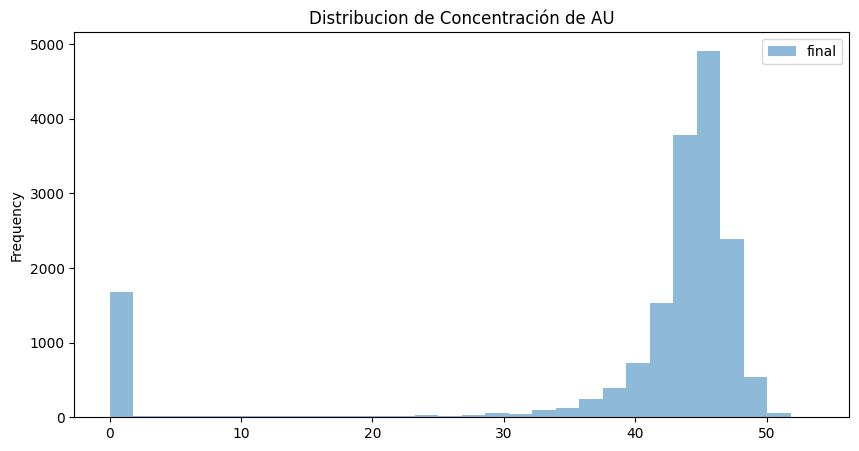

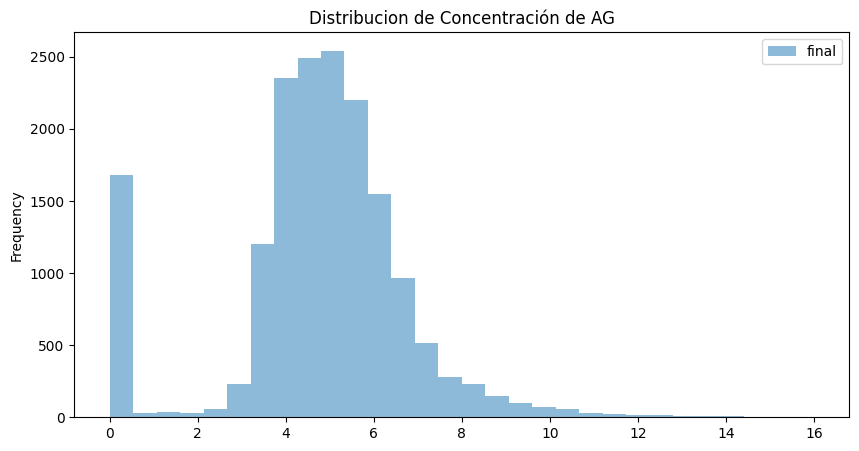

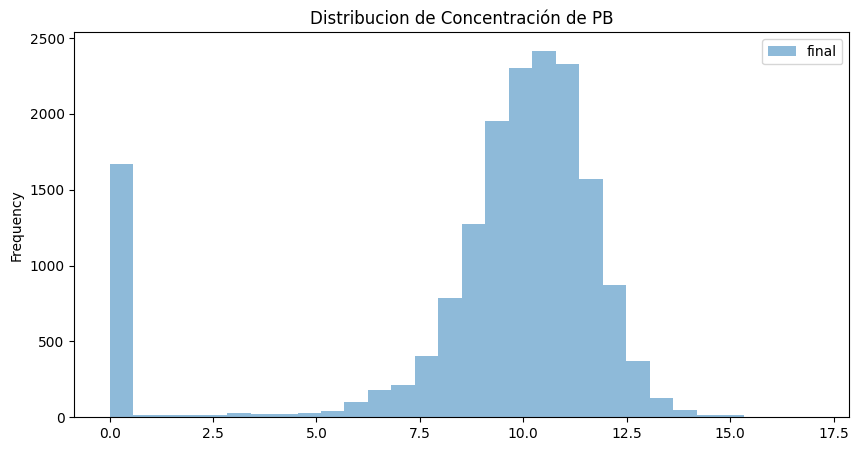

In [36]:
metals = ['au', 'ag', 'pb'] 
stages = ['rougher,' 'primary_cleaner', 'final']

for metal in metals: 
    plt.figure(figsize = (10, 5))
    for stage in stages: 
        col = f'{stage}.output.concentrate_{metal}'
        if col in data_train.columns:
            data_train[col].plot(kind='hist', alpha=0.5, bins=30, label = stage)

    plt.title(f'Distribucion de Concentración de {metal.upper()}')
    plt.legend()
    plt.show() 

**2.2 Tamaño de las particulas**

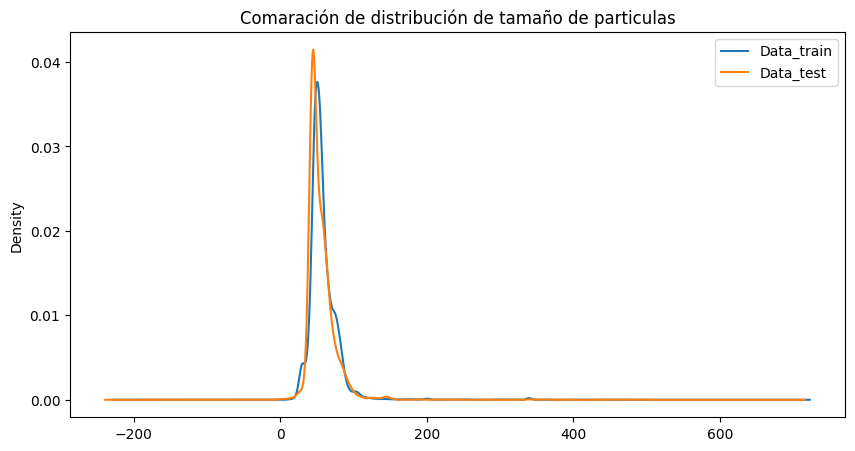

In [37]:
plt.figure(figsize=(10,5))
data_train['rougher.input.feed_size'].plot(kind='kde', label='Data_train')
data_test['rougher.input.feed_size'].plot(kind='kde', label='Data_test')
plt.title('Comaración de distribución de tamaño de particulas')
plt.legend()
plt.show()

**2.3 Concentraciones totales**

In [38]:
def check_total_concentracion(df, stage): 
    cols = [c for c in df.columns if f'{stage}.output.concentrate_' in c]
    df[f'{stage}.concentrate_total'] = df[cols].sum(axis=1) 
    return df[f'{stage}.concentrate_total']

for stage in ['rougher', 'primary_cleaner', 'final']:
    total = check_total_concentracion(data_train, stage)
    print(f'\nConcentración total en {stage}:\n')
    print(total.describe())


Concentración total en rougher:

count    16860.000000
mean        60.302695
std         23.679468
min          0.000000
25%         61.679236
50%         68.332115
75%         73.017601
max         90.964431
Name: rougher.concentrate_total, dtype: float64

Concentración total en primary_cleaner:

count    16860.000000
mean        54.424623
std         20.131612
min          0.000000
25%         55.821213
50%         61.103229
75%         64.860488
max         76.918076
Name: primary_cleaner.concentrate_total, dtype: float64

Concentración total en final:

count    16860.000000
mean        61.630331
std         21.373253
min          0.000000
25%         66.780933
50%         68.828223
75%         70.704257
max         80.210644
Name: final.concentrate_total, dtype: float64


Se pueden observar valores con un minimo de 0, estos son considerados como valores anormales ya que pueden alterar altamente nuestros resultados debido a la variacion extrema que se tiene. Asimismo estos valores de 0 pueden indicar errores de medicion o datos faltantes. 

En este caso se hara la eliminacion de estos datos para poder tener los mejores resultados

In [40]:
# Columnas de interes 
columns = ['rougher.concentrate_total',
       'primary_cleaner.concentrate_total',
       'final.concentrate_total']

# Recortar valores extremos 
data_train_clean = data_train[(data_train[columns[0]] > 0) & 
                              (data_train[columns[1]] > 0) & 
                              (data_train[columns[2]] > 0)]

# Verificacion de resultados 
for stage in columns:
    print(f'\nConcentración total en {stage}:\n')
    print(data_train_clean[stage].describe())


Concentración total en rougher.concentrate_total:

count    15111.000000
mean        66.247448
std         14.964968
min          0.039898
25%         64.562229
50%         69.094506
75%         73.536328
max         90.964431
Name: rougher.concentrate_total, dtype: float64

Concentración total en primary_cleaner.concentrate_total:

count    15111.000000
mean        58.701480
std         13.611843
min          0.040000
25%         57.645204
50%         61.524784
75%         65.129655
max         76.918076
Name: primary_cleaner.concentrate_total, dtype: float64

Concentración total en final.concentrate_total:

count    15111.000000
mean        66.649840
std         12.666152
min          0.040000
25%         67.417515
50%         69.051603
75%         70.844459
max         80.210644
Name: final.concentrate_total, dtype: float64


# 3. Construir Modelo

**3.1 Funcion para sMAPE**

In [41]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def final_smape(y_true, y_pred):
    y_pred_rougher = y_pred[:,0]
    y_pred_final = y_pred[:,1]
    
    y_true_rougher = y_true['rougher.output.recovery']
    y_true_final = y_true['final.output.recovery']
    
    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)
    return 0.25*smape_rougher + 0.75*smape_final

**3.2 Entrenar modelo**

In [42]:
# Identificar columnas comunes entre train y test
common_feat = [col for col in data_train.columns if col not in ['rougher.output.recovery', 'final.output.recovery'] and col in data_test.columns]

# Separar target y features
feat_train = data_train_clean[common_feat].drop('date', axis=1)
target_train = data_train_clean[['rougher.output.recovery', 'final.output.recovery']]

feat_test = data_test[common_feat].drop('date', axis=1)

In [43]:
# Entrenar modelo // Random Forest Regressor 

model = RandomForestRegressor(n_estimators=100, random_state=12345)
model.fit(feat_train, target_train)

# Predecir valores
y_pred = model.predict(feat_test)

In [44]:
# Calcular sMAPE
y_ture = data_full.loc[feat_test.index, ['rougher.output.recovery', 'final.output.recovery']]
smape_score = final_smape(y_ture, y_pred)

print(f'sMAPE score on test data: {smape_score:.2f}')

sMAPE score on test data: 12.40


**Evaluación de múltiples modelos**

In [45]:
# Validacion temporal 
tscv = TimeSeriesSplit(n_splits=5)

# Modelos a evaluar 
models = {
    'Linear Regression' : LinearRegression(),
    'Decision Tree Regressor' : DecisionTreeRegressor(max_depth = 5, random_state=12345),
    'Random Forest Regressor' : RandomForestRegressor(n_estimators=50, random_state=12345)
}

# Evaluacion de modelos con validacion cruzada 
results = {}
for name, model in models.items():
    cv_score = cross_val_score(
        model, feat_train, target_train, cv=tscv,
        scoring=make_scorer(final_smape, greater_is_better=False), n_jobs=-1
    )
    
    results[name] = cv_score
    print(f'{name}:') 
    print(f'\tsMAPE mean: {np.mean(-cv_score):.2f} (± {np.std(cv_score):.2f})')
    print('-'*30)


Linear Regression:
	sMAPE mean: 14.45 (± 4.61)
------------------------------
Decision Tree Regressor:
	sMAPE mean: 14.07 (± 7.29)
------------------------------
Random Forest Regressor:
	sMAPE mean: 10.72 (± 1.42)
------------------------------


In [46]:
# Entrenar el mejor modelo en todos los datos 
best_model_name = min(results, key=lambda k: np.mean(results[k]))
best_model = models[best_model_name].fit(feat_train, target_train)

y_pred_best = best_model.predict(feat_test)
smape_score_best = final_smape(y_ture, y_pred_best)

In [47]:
print(f' Best model: {best_model_name}') 
print(f' sMAPE score on test data: {smape_score_best:.2f}')

 Best model: Linear Regression
 sMAPE score on test data: 14.27


# Conclusión

En este caso Random Forest demostro ser superior al obtener un sMAPE de 10.72 (±1.42) superando de manera significativa a la Regresion Lineal (14.45) y al Arbol de decision (14.07).
La baja desviacion estandar en Random Forest nos indica que este tiene consistencia en sus predicciones a diferencia del Arbol de decisiones cuya alta variabilidad sugiere inestabildad.

Tabla Resumen de Resultados:

|Modelo             | sMAPE (Validación) | ± Desviación | sMAPE (Test)|
|-------------------|--------------------|--------------|-------------|
|Regresión Lineal   | 14.45              | 4.61         | -           |
|Árbol de Decisión  | 14.07              | 7.29         | -           |
|Random Forest      | 10.72              | 1.42         | 12.58       |

El modelo de **Random Forest Regressor** es la mejor opcion actual, balanceando capacidad predicitiva y estabilidad. Sin embargo su implementacion deberia ir acompañada de un monitoreo continueo del error y actualizaciones periodicas del modelo con nuevos datos. 